# Imports

In [1]:
from pathlib import Path
import pickle
import pandas as pd

import seaborn as sns
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast
from applefy.utils.positions import center_subpixel

from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio

from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma

# Load the data

In [2]:
dataset_name = "HD22049_303_199_C-0065_C_"

In [3]:
dataset_file = Path("/fast/mbonse/s4/30_data/" + dataset_name + ".hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/07_partial_contrast_grid/")

In [4]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object",
    psf_template_tag="psf_template",
    para_tag="header_object/PARANG")

dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6

science_data = science_data[:, 12:-12, 12:-12]

psf_template = np.median(raw_psf_template_data, axis=0)
psf_template = psf_template - np.min(psf_template)

# Create the full contrast grid config files

In [5]:
tmp_exp_root = experiment_root_dir / dataset_file.name[:-5]
tmp_exp_root.mkdir(exist_ok=True)

In [6]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=1., # A factor to account e.g. for ND filters
    checkpoint_dir=tmp_exp_root)

## Design fake planet experiments

In [7]:
# fake planet brightness
flux_ratios_mag = np.linspace(5., 13, 17)
flux_ratios = mag2flux_ratio(flux_ratios_mag)

print("Brightness of fake planets in mag: " + str(flux_ratios_mag))
print("Planet-to-star flux ratio: " + str(flux_ratios))

Brightness of fake planets in mag: [ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13. ]
Planet-to-star flux ratio: [1.00000000e-02 6.30957344e-03 3.98107171e-03 2.51188643e-03
 1.58489319e-03 1.00000000e-03 6.30957344e-04 3.98107171e-04
 2.51188643e-04 1.58489319e-04 1.00000000e-04 6.30957344e-05
 3.98107171e-05 2.51188643e-05 1.58489319e-05 1.00000000e-05
 6.30957344e-06]


In [8]:
center = center_subpixel(science_data[0])
separations = np.arange(fwhm, fwhm*6.5, fwhm / 2)[1:]
separations/3.6

array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ])

In [9]:
num_fake_planets = 3

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


# 4. Restore results

## 4.1 cADI

In [10]:
from applefy.utils.file_handling import save_as_fits
from s4hci.detection_limits.applefy_wrapper import PCADataReductionGPU, cADIDataReduction, S4DataReduction

In [11]:
cadi_model = cADIDataReduction()

In [12]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=cadi_model,
    num_parallel=1)

Running fake planet experiments...

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:02<00:00, 201.20it/s]

[DONE]


## PCA

In [13]:
pca_numbers = np.concatenate(
        [np.arange(0, 20, 2)[1:],
         np.arange(20, 50, 5),
         np.arange(50, 100, 10),
         np.arange(100, 200, 20),
         np.arange(200, 550, 50)])

pca_model = PCADataReductionGPU(
    approx_svd=10000,
    pca_numbers=pca_numbers,
    device="cpu",
    verbose=True)

In [14]:
old_results = contrast_instance.results_dict
contrast_instance.run_fake_planet_experiments(
    algorithm_function=pca_model,
    num_parallel=1)
contrast_instance.results_dict.update(old_results)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [01:15<00:00,  6.75it/s]

[DONE]


## S4

In [15]:
pre_trained_noise_model = "/fast/mbonse/s4/70_results/06_contrast_curves/01_train_each_model_once/" + dataset_name + "/models/noise_model_fine_tuned.pkl"
pre_trained_normalization = "/fast/mbonse/s4/70_results/06_contrast_curves/01_train_each_model_once/" + dataset_name + "/models/normalization_model.pkl"

In [16]:
special_names = ["raw_model", "planet_learned", "planet_learned_fine_tune"]

for special_name in special_names:
    s4_model = S4DataReduction(
        special_name=special_name,
        noise_model_file=pre_trained_noise_model,
        normalization_model_file=pre_trained_normalization,
        device="cpu",
        work_dir=None,
        verbose=True)
    
    old_results = contrast_instance.results_dict
    contrast_instance.run_fake_planet_experiments(
        algorithm_function=s4_model,
        num_parallel=1)
    contrast_instance.results_dict.update(old_results)

Running fake planet experiments...

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:05<00:00, 101.99it/s]


[DONE]
Running fake planet experiments...

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:04<00:00, 102.56it/s]


[DONE]
Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:05<00:00, 99.71it/s]

[DONE]


In [17]:
contrast_instance.results_dict.keys()

dict_keys(['s4_mean_planet_learned_fine_tune', 's4_median_planet_learned_fine_tune', 's4_mean_planet_learned', 's4_median_planet_learned', 's4_mean_raw_model', 's4_median_raw_model', 'PCA_002_components', 'PCA_004_components', 'PCA_006_components', 'PCA_008_components', 'PCA_010_components', 'PCA_012_components', 'PCA_014_components', 'PCA_016_components', 'PCA_018_components', 'PCA_020_components', 'PCA_025_components', 'PCA_030_components', 'PCA_035_components', 'PCA_040_components', 'PCA_045_components', 'PCA_050_components', 'PCA_060_components', 'PCA_070_components', 'PCA_080_components', 'PCA_090_components', 'PCA_100_components', 'PCA_120_components', 'PCA_140_components', 'PCA_160_components', 'PCA_180_components', 'PCA_200_components', 'PCA_250_components', 'PCA_300_components', 'PCA_350_components', 'PCA_400_components', 'PCA_450_components', 'PCA_500_components', 'cADI'])

# Compute the contrast grid

In [18]:
# Use apertures pixel values
photometry_mode_planet = AperturePhotometryMode(
    "AS", # or "ASS"
    psf_fwhm_radius=fwhm/2,
    search_area=0.5)

photometry_mode_noise = AperturePhotometryMode(
    "AS",
    psf_fwhm_radius=fwhm/2)

# Use spaced pixel values
photometry_mode_planet = AperturePhotometryMode(
    "FS", # or "P"
    psf_fwhm_radius=fwhm/2,
    search_area=0.5)
photometry_mode_noise = AperturePhotometryMode(
    "P",
    psf_fwhm_radius=fwhm/2)

In [19]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [20]:
statistical_test = TTest()

In [21]:
contrast_curves_grid, contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=statistical_test,
    num_cores=8,
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    num_rot_iter=10,
    safety_margin=2.5,
    pixel_scale=0.02718)

Computing contrast grid for s4_mean_planet_learned_fine_tune
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for s4_median_planet_learned_fine_tune
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.p

........................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for s4_mean_planet_learned
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for s4_median_planet_learned
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for s4_mean_raw_model
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for s4_median_raw_model
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_002_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_004_components
Computing contrast grid with multiprocessing:
................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_006_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_008_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.p

.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_010_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.p

........................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_012_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_014_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.p

..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_016_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_018_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_020_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_025_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_030_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_035_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.p

.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_040_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.p

.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_045_components
Computing contrast grid with multiprocessing:
................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_050_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_060_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_070_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_080_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.p

.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_090_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_100_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_120_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_140_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_160_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_180_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.p

........................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_200_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_250_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_300_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_350_components
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_400_components
Computing contrast grid with multiprocessing:
................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_450_components
Computing contrast grid with multiprocessing:
.................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


........

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.p

........................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for PCA_500_components
Computing contrast grid with multiprocessing:
................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]
Computing contrast grid for cADI
Computing contrast grid with multiprocessing:
..................................................................................................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..............

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....[DONE]


# Plot the grid

In [22]:
from copy import deepcopy

In [23]:
baseline_grids = deepcopy(contrast_grids)

special_names = ["raw_model", "planet_learned", "planet_learned_fine_tune"]
for special_name in special_names:
    del baseline_grids["s4_mean_" + special_name]
    del baseline_grids["s4_median_" + special_name]
    
baseline_grids.keys()

dict_keys(['PCA_002_components', 'PCA_004_components', 'PCA_006_components', 'PCA_008_components', 'PCA_010_components', 'PCA_012_components', 'PCA_014_components', 'PCA_016_components', 'PCA_018_components', 'PCA_020_components', 'PCA_025_components', 'PCA_030_components', 'PCA_035_components', 'PCA_040_components', 'PCA_045_components', 'PCA_050_components', 'PCA_060_components', 'PCA_070_components', 'PCA_080_components', 'PCA_090_components', 'PCA_100_components', 'PCA_120_components', 'PCA_140_components', 'PCA_160_components', 'PCA_180_components', 'PCA_200_components', 'PCA_250_components', 'PCA_300_components', 'PCA_350_components', 'PCA_400_components', 'PCA_450_components', 'PCA_500_components', 'cADI'])

In [24]:
all_grids = np.array([tmp_grid.applymap(fpf_2_gaussian_sigma).values for tmp_grid in baseline_grids.values()])

In [25]:
over_all_best = deepcopy(contrast_grids["cADI"])
over_all_best.iloc[:, :] = np.max(all_grids, axis=0)
over_all_best.index = flux_ratio2mag(over_all_best.index)

In [26]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):

    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"Confidence [$\sigma_{\mathcal{N}}$]")

    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7,
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)

    ylabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)
    xlabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_xticklabels()]
    _=heat.set_xticklabels(xlabels)

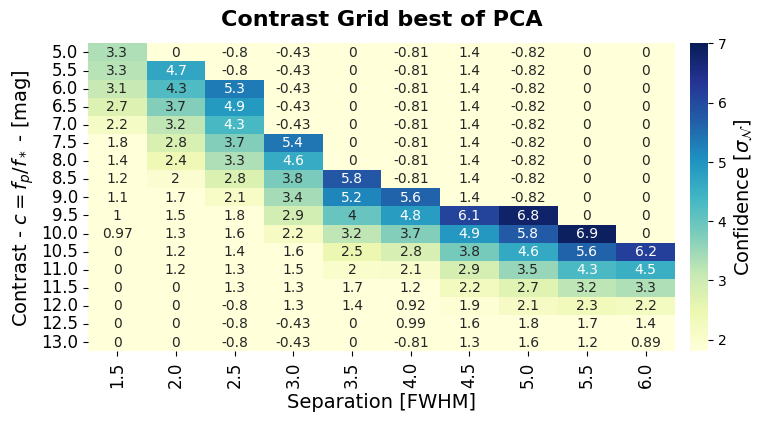

In [27]:
fig = plt.figure(figsize=(8, 4))

gs0 = fig.add_gridspec(1, 1)
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0],
    wspace=0.05, width_ratios=[1, 0.03])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

# Plot the contrast grid
plot_contrast_grid(
    contrast_grid_axis=contrast_ax,
    colorbar_axis=colorbar_ax,
    contrast_grid=over_all_best)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [FWHM]", size=14)
contrast_ax.set_title(
    "Contrast Grid best of PCA",
    fontsize=16,
    fontweight="bold",
    y=1.03)

contrast_ax.tick_params(
    axis='both',
    which='major',
    labelsize=12)

# Save the figure
fig.patch.set_facecolor('white')
plt.savefig("contrast_grid_pca_best_off.pdf", bbox_inches='tight')

In [28]:
lookup_table = deepcopy(contrast_instance.contrast_results["PCA_002_components"].idx_table)
lookup_table.columns = flux_ratio2mag(lookup_table.columns)
lookup_table.index = lookup_table.index / 3.6
lookup_table

flux_ratio,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5,12.0,12.5,13.0
separation,,,,,,,,,,,,,,,,,
1.5,1,11,21,31,41,51,61,71,81,91,101,111,121,131,141,151,161
2.0,2,12,22,32,42,52,62,72,82,92,102,112,122,132,142,152,162
2.5,3,13,23,33,43,53,63,73,83,93,103,113,123,133,143,153,163
3.0,4,14,24,34,44,54,64,74,84,94,104,114,124,134,144,154,164
3.5,5,15,25,35,45,55,65,75,85,95,105,115,125,135,145,155,165
4.0,6,16,26,36,46,56,66,76,86,96,106,116,126,136,146,156,166
4.5,7,17,27,37,47,57,67,77,87,97,107,117,127,137,147,157,167
5.0,8,18,28,38,48,58,68,78,88,98,108,118,128,138,148,158,168
5.5,9,19,29,39,49,59,69,79,89,99,109,119,129,139,149,159,169


In [29]:
test_setup = contrast_instance.experimental_setups["0096c"]
print(flux_ratio2mag(test_setup["flux_ratio"]))
print(test_setup["separation"] / 3.6)

9.5
4.0


# Plot the S4 Contrast Grids

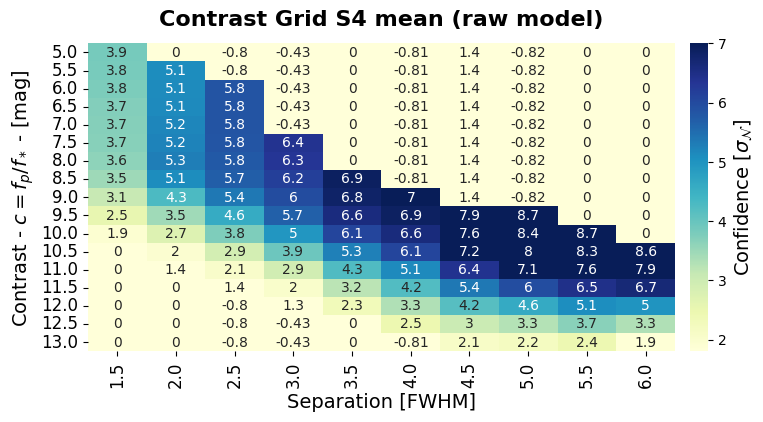

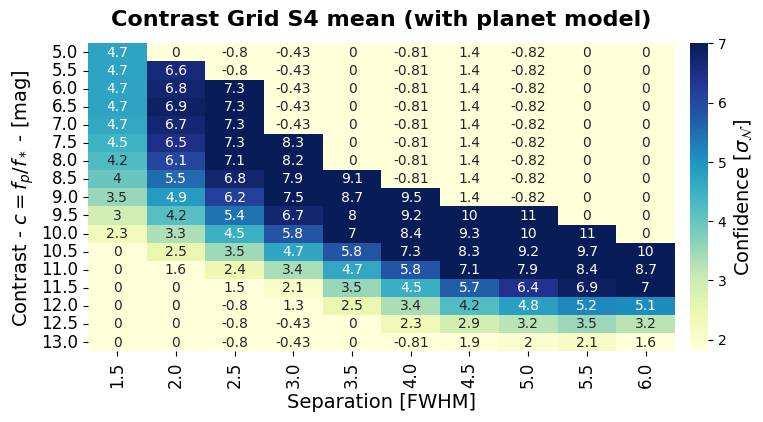

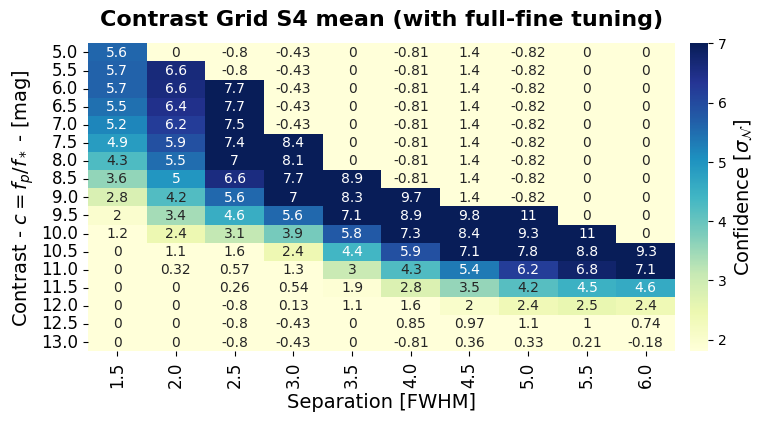

In [30]:
for tmp_model, model_name in [
    ("s4_mean_raw_model", "(raw model)"),
    ("s4_mean_planet_learned", "(with planet model)"),
    ("s4_mean_planet_learned_fine_tune", "(with full-fine tuning)")]:

    s4_contrast_grid = deepcopy(contrast_grids[tmp_model])
    s4_contrast_grid.index = flux_ratio2mag(s4_contrast_grid.index)
    s4_contrast_grid = s4_contrast_grid.applymap(fpf_2_gaussian_sigma)

    fig = plt.figure(figsize=(8, 4))

    gs0 = fig.add_gridspec(1, 1)
    gs0.update(wspace=0.0, hspace=0.2)
    gs1 = gridspec.GridSpecFromSubplotSpec(
        1, 2, subplot_spec = gs0[0],
        wspace=0.05, width_ratios=[1, 0.03])

    # All axis we need
    contrast_ax = fig.add_subplot(gs1[0])
    colorbar_ax = fig.add_subplot(gs1[1])

    # Plot the contrast grid
    plot_contrast_grid(
        contrast_grid_axis=contrast_ax,
        colorbar_axis=colorbar_ax,
        contrast_grid=s4_contrast_grid)

    colorbar_ax.yaxis.label.set_size(14)

    contrast_ax.set_ylabel(
        "Contrast - $c = f_p / f_*$ - [mag]", size=14)
    contrast_ax.set_xlabel(
        r"Separation [FWHM]", size=14)
    contrast_ax.set_title(
        "Contrast Grid S4 mean " + model_name,
        fontsize=16,
        fontweight="bold",
        y=1.03)

    contrast_ax.tick_params(
        axis='both',
        which='major',
        labelsize=12)

    # Save the figure
    fig.patch.set_facecolor('white')
    plt.savefig("contrast_grid_" + tmp_model + ".pdf", bbox_inches='tight')

# Merge the big residual

In [31]:
all_residuals = []

for tmp_method_name, tmp_result in contrast_instance.contrast_results.items():
    
    all_residuals.append(tmp_result.residuals)
    print(tmp_method_name)

s4_mean_planet_learned_fine_tune
s4_median_planet_learned_fine_tune
s4_mean_planet_learned
s4_median_planet_learned
s4_mean_raw_model
s4_median_raw_model
PCA_002_components
PCA_004_components
PCA_006_components
PCA_008_components
PCA_010_components
PCA_012_components
PCA_014_components
PCA_016_components
PCA_018_components
PCA_020_components
PCA_025_components
PCA_030_components
PCA_035_components
PCA_040_components
PCA_045_components
PCA_050_components
PCA_060_components
PCA_070_components
PCA_080_components
PCA_090_components
PCA_100_components
PCA_120_components
PCA_140_components
PCA_160_components
PCA_180_components
PCA_200_components
PCA_250_components
PCA_300_components
PCA_350_components
PCA_400_components
PCA_450_components
PCA_500_components
cADI


In [32]:
all_residuals = np.array(all_residuals)

In [33]:
save_as_fits(all_residuals, experiment_root_dir / Path("merged_residuals_pca_HD22049_303_199_C-0065_C.fits"))

# Save the S4 results

In [34]:
s4_residuals_with_planet = contrast_instance.contrast_results["s4_mean_planet_learned"].residuals
s4_residuals_raw = contrast_instance.contrast_results["s4_mean_raw_model"].residuals

In [35]:
save_as_fits(s4_residuals_with_planet, experiment_root_dir / 
             Path("merged_residuals_s4_planet_HD22049_303_199_C-0065_C.fits"))

save_as_fits(s4_residuals_raw, experiment_root_dir / 
             Path("merged_residuals_s4_raw_HD22049_303_199_C-0065_C.fits"))